# Le voyageur de commerce

L'objectif est de trouver un chemin reliant des points. Les points représente des ville. Le chemin représente le circuit d'un voyageur de commerce. Ce dernier devant rentrer chez lui à la fin, le chemin doit revenir sur sont point de départ.

Par exemple ci-dessous, les villes sont disposées en cercle,  le chemin dessiné n'est clairement pas le plus court.

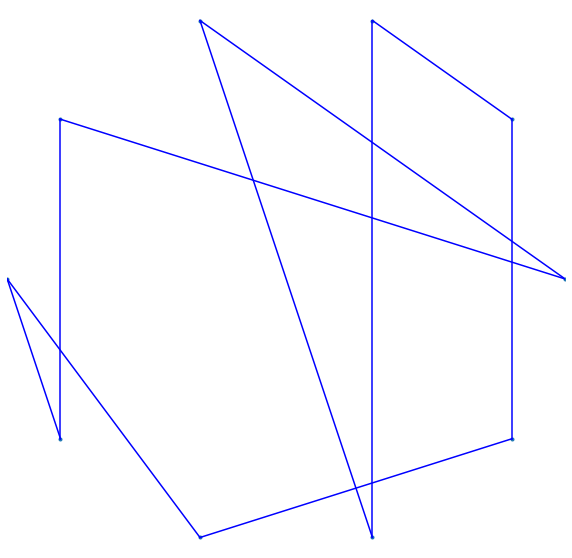

Quand les points sont disposé en cercle, la solution est triviale: Il suffit de prendre le chemin qui fait un cercle.


Mais pour une disposition générique des points, ce problème est très complexe à résoudre. C'est un problème NP-complet: on ne peut pas le résoudre en un temps polynomial (par rapport au nombre de ville).

***A vous:*** Si $n$ est le nombre de ville, et si l'on teste toutes les possibilités, combien de teste doit-on effectuer?

## L'environnement

In [ ]:
%reset -f

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

Dans la classe suivante:

* les villes sont placées dans le constructeur. L'option `cities_in_circle=True` permet de tester visuellement notre programme. On l'utilisera tout au long du TP. Mais bien entendu, le cas interessant c'est `cities_in_circle=False`
* la méthode `render` dessine le parcours du voyageur de commerce.
* l'attribut `state` donne l'ordre des ville dans le parcours
* la méthode `distance()` calcule la longueur du parcours

In [ ]:
class Env_commerce:

    def __init__(self,
                 size,
                 cities_in_circle=True
                 ):

        print(f"Création de l'environnement Env_commerce, size={size}, cities_in_circle={cities_in_circle}")

        self.size=size
        self.cities_in_circle=cities_in_circle

        if cities_in_circle:
            theta=np.linspace(0,2*np.pi,size,endpoint=False)

            #on mélange l'ordre des villes, toujours de la même manière
            np.random.seed(32)
            np.random.shuffle(theta)

            self.cities=np.stack([np.cos(theta),np.sin(theta)],axis=1)

        else:
            self.cities=np.random.uniform(-1,1,size=[size,2])

        self.reset()


    def reset(self):
        self.state=np.arange(self.size)
        #autre possibilité pour repartir d'un état aléatoire
        #np.random.shuffle(np.arange(self.size))
        return self.state


    def distance(self,state=None):
        if state is None:
            state=self.state

        cities_ord=self.cities[state]
        #(C[i+1,j]-C[i,j])**2
        dist=np.sum(np.sqrt(np.sum((cities_ord-np.roll(cities_ord,1,axis=0))**2,axis=1)))
        return dist


    def reward(self,state=None):
        pass#TODO
        """
        plus la distance est courte et plus la reward doit être grande
        """


    def render(self,state=None):

        if state is None:
            state=self.state

        fig, ax = plt.subplots(figsize=(10,10))

        ax.axis("off")
        ax.set_xlim(-1,1)
        ax.set_ylim(-1,1)
        ax.plot(self.cities[:,0],self.cities[:,1],".")
        cities_ord=self.cities[state]

        for i in range(self.size):
            ax.plot([cities_ord[i,0],cities_ord[(i+1)%self.size,0]],[cities_ord[i,1],cities_ord[(i+1)%self.size,1]],"b")


    def random_action(self,size):
        pass
        ##TODO

    def step(self,action):
        #TODO
        """ici il faut modifier le `state` en fonction de `action` """
        reward=self.reward()
        done=False #ne s'arrête jamais

        return self.state, reward , done

def test():
    env=Env_commerce(10)
    env.render()
    print("distance à parcourir:",env.distance())
test()

***A vous:*** Expliquez le calcul de la distance de parcours, en particulier: à quoi sert le `np.roll`.

### Action

Implémenter les méthodes non-finies de la classe `Env_commerce`.

Commencer par définir la méthode `step(action)` qui modifie le parcours selon une `action`. Dans un premier temps, `action` sera simplement un entier. Il y a plein de technique possible, inventez la votre.

Ensuite implémenter la méthode `random_action()` qui génére une action aléatoire. Par exemple, effecturant plusieurs fois `env.step(env.random_action()` j'obtiens les parcours successifs dessiné ci-dessous.


J'ai ajouté des couleurs pour mieux comprendre le role de mon action (le segment vert relie les villes 0 et 1, tandis que la ville rouge porte le numéro de mon action). Mais peut importe, vérifiez simplement que votre action permet bien d'explorer l'ensemble des parcours (=state=permutation).

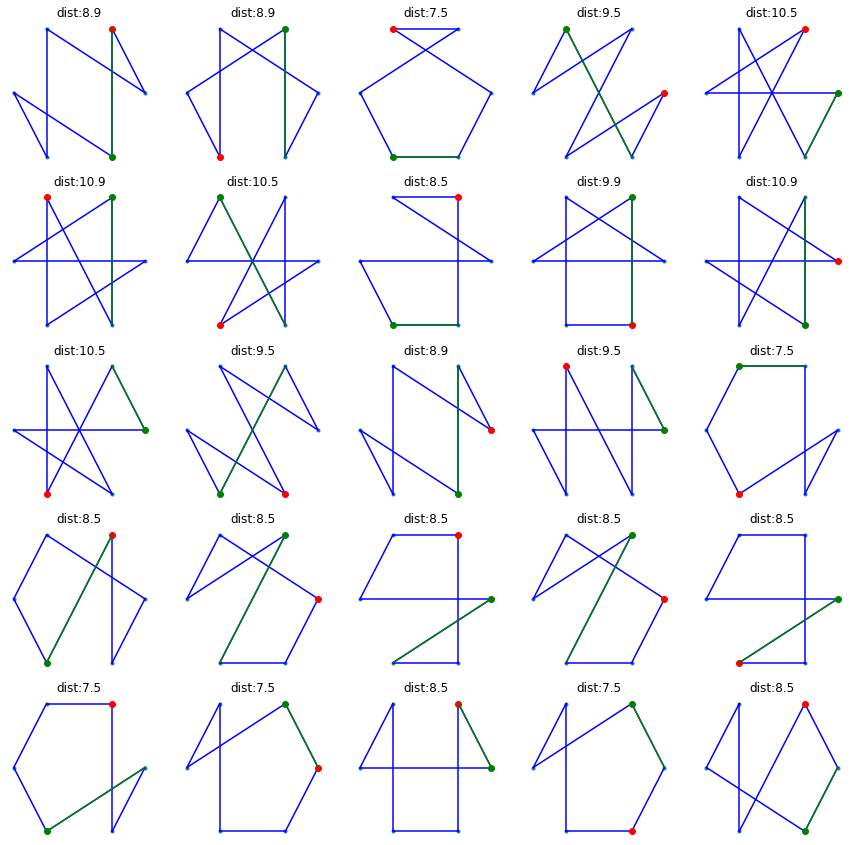

## Une matrice indicée par n'importe quoi

Dans notre problème:
* un `state` est une permutation
* une `action` est un entier, mais ça pourrait être aussi un couple ou même un tuple.

Pour faire du $Q$-learning, on a donc besoin d'une matrice `Q[state,action]` qui puisse être indicée par n'importe quoi. De plus, on ne veut pas forcément explorer toutes les permutations, on va donc coder une structure de matrice creuse à l'aide de dictionnaire python.

In [ ]:
class Q_dico:
    def __init__(self):
        self.data={}

    def get(self,state,action):
        data_state=self.data.get(state)
        if data_state is None:
            return 0.
        else:
            return data_state.get(action,0.)

    def update(self,state,action,value):
        data_state=self.data.get(state,{})
        data_state[action]=value
        self.data[state]=data_state


    def best_action(self,state):
        #doit renvoyer le couple (best_action,best_value)
        #si aucune action n'a été enregistrée pour ce 'state', renvoie (None,0.)
        pass

Implémenter la méthode `best_action`. Tester cette classe en exécutant le programme suivante:

    def test():
        Q=Q_dico()
        Q.update((0,1,2),1,3)
        Q.update((0,1,2),1,4) #écrase la valeur précédente
        Q.update((0,1,2),2,5)
        Q.update((2,1,0),1,6)
        val=Q.get((0,1,2),1)
        print("val",val)
        assert val==4
        val=Q.get((0,1,2),2)
        print("val",val)
        assert val==5
        val=Q.get((2,0,1),2)
        print("val",val)
        assert val==0.
        val=Q.get((2,1,0),2)
        print("val",val)
        assert val==0.

        best_action,best_value=Q.best_action((0,1,2))
        print(f"best_action={best_action},best_value={best_value}")
        assert best_action,best_value==(2,5)
        best_action,best_value=Q.best_action((2,0,1))
        print(f"best_action={best_action},best_value={best_value}")
        assert best_action is None and best_value==0.

***Remarque:*** Si l'on aime bien la belle programmation, on pourrait implémenter les méthodes `__getitem__` et. `__setitem__` générique à python et du coup notre matrice `Q` pourrait être utilisée comme une vraie matrice, par exemple:

        Q[(0,1,2),2]=5

à la place de

        Q.update((0,1,2),2,5)

Mais  ne vous lancer pas dans ce changement, ce n'est pas le but du TP.

## SARSA

Maintenant c'est à vous de finir le programme. Vous pouvez partir du programme SARSA du labyrinthe, et le modifier pour trouver une bonne solution au problème du voyageur de commerce.




### Imposé:

Votre mission et de trouver la meilleurs solution possible pour un nombre de ville:

    size=30

et cela dans un temps imposé de 12 secondes (=0.2 minute).


Mon résultat est d'environ un parcours d'une longueur de

    env.distance(best_state)=26,0...

Malgré le côté aléatoire de l'algo, d'un run à l'autre, on obtient à peu près la même  longueur. Mais le dessin du parcours change bien entendu.  Voici par exemple un dessin obtenu:

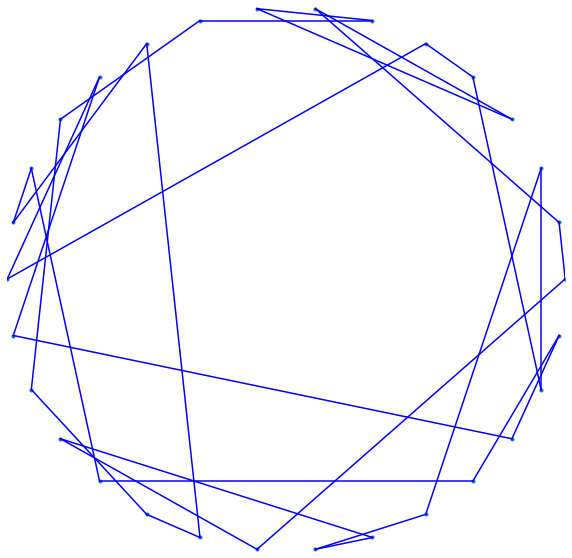

### Suggestion

Voici les paramètres que j'ai utilisé perso:

taux de décroissance d'epsilon:

    epsilon_decreate_rate=0.99

Durée d'un épisode=nombre de env.step() que l'on fait avant de repartir de zéro avec un env.reset()

    depth_of_exploration=500

Le "discount factor" $\gamma$, qui apparait dans la récompense-cumulée
$
\sum_{t \geq 0} \gamma^{t} r_{t}
$:

    gamma = 0.95


Je n'ai pas utilisé d'inertie (donc pas de paramètre `alpha`).



La manière dont je modifie le parcours dans la méthode `step` est gardé secrete. Mais j'ai essayé plusieurs technique, et cela ne change pas radicalement le résultat.

## Comparaison avec une recherche exhaustive

### Itérer sur les permutations

In [ ]:
import itertools

list_to_permut = range(3)#np.arange(4)

# no length entered so default length
# taken as 4(the length of string GeEK)
permut_iter = itertools.permutations(list_to_permut)

# Print the obtained permutations
for p in permut_iter:
    print(p)

In [ ]:
def find_the_best(size):

    permut_iter = itertools.permutations(range(size))
    env=Env_commerce(size)
    best_distance=float("inf")
    best_state=None
    ti0=time.time()

    for permut in permut_iter:
        state=np.array(permut)
        dist=env.distance(state)
        if dist<best_distance:
            best_distance=dist
            best_state=state.copy()

    duration=time.time()-ti0
    print(f"duration:{duration:.1f}")

    env.render(state=best_state)
    print(f"meilleurs distance trouvée:{best_distance:.1f}")

find_the_best(8)

Donc, nous mettons environ 1,5 secondes pour 8 villes. Il est facile d'extrapoler le temps que l'on mettrai pour plus de ville:

In [ ]:
import math

In [ ]:
def compute_duration():
    #pour 8! on a mis 1.5 seconde
    sizes=range(5,12)
    durations=[]
    for size in sizes:
        durations.append(math.factorial(size)/math.factorial(8)*1.5)
    fig,ax=plt.subplots()
    ax.plot(sizes,durations)
    ax.set_xlabel("sizes")
    ax.set_ylabel("durations")
    ax.set_xticks(sizes)
compute_duration()

On voit qu'on ne peut vraiment pas utiliser la recherche exhaustive pour 30 villes.

### Exo: en limitant le temps

***A vous:*** Modifier l'algo précédent, pour qu'il itére sur les permutations pendant un temps donné. La signature sera donc:

    def find_the_best(size,max_minutes=None)


Reprenez `size=30`, mettez `max_minutes=0.2` et observer la distance obtenue.
